In [1]:
from SynTemp.SynUtils.utils import load_database, load_from_pickle
data = load_from_pickle('./Data/uspto/uspto_its_graph_rules_cluster.pkl.gz')

In [2]:
from SynTemp.SynMØD.naive_cluster import NaiveCluster
node_label_names = ["element", "charge"]
naive_cluster = NaiveCluster(node_label_names=node_label_names, node_label_default=["*", 0], edge_attribute="order")
its_graph_rules_cluster = naive_cluster.process_rules_clustering(data, rule_column='GraphRules')

In [3]:
its_graph_rules_cluster[0]

{'R-id': 'USPTO_50K_26',
 'ITSGraph': (<networkx.classes.graph.Graph at 0x7f258655fa10>,
  <networkx.classes.graph.Graph at 0x7f2574c72e50>),
 'GraphRules': (<networkx.classes.graph.Graph at 0x7f2574c82790>,
  <networkx.classes.graph.Graph at 0x7f2574c82fd0>),
 'naive_cluster': 0,
 'Reaction Type': 'Single Cyclic',
 'Rings': [4]}

In [4]:
from SynTemp.SynUtils.utils import stratified_random_sample
import pandas as pd
sampled_data = stratified_random_sample(its_graph_rules_cluster, property_key='naive_cluster', samples_per_class=1, seed=23)
pd.DataFrame(sampled_data)['Reaction Type'].value_counts()

/tmp/ipykernel_1757720/1165709729.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Reaction Type
Single Cyclic     119
None               39
Complex Cyclic     20
Acyclic            17
Name: count, dtype: int64

In [5]:
single = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Single Cyclic']
complex = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Complex Cyclic']
neither = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'None']
acyclic = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Acyclic']

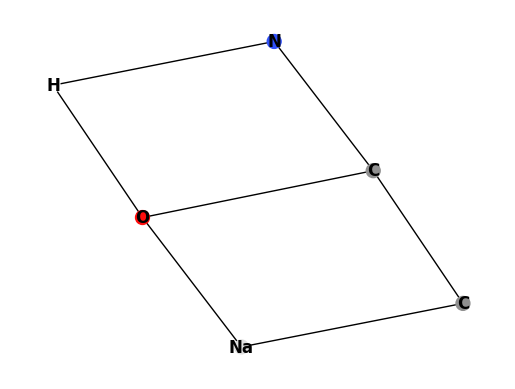

In [7]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer()
vis.graph_vis(complex[4], show_node_labels=True)

In [112]:
import networkx as nx
import numpy as np
from typing import Any, Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
class GrapRuleDecompose:
    @staticmethod
    def get_key_by_value(dictionary: Dict[Any, Any], value: Any) -> Optional[Any]:
        """
        Retrieve a key in a dictionary corresponding to a specified value.

        Parameters:
        - dictionary (Dict[Any, Any]): The dictionary to search through.
        - value (Any): The value to find the corresponding key for.

        Returns:
        - Optional[Any]: The key associated with the specified value, or None if not found.
        """
        return next((key for key, val in dictionary.items() if val == value), None)

    @staticmethod
    def is_connected(graph: nx.Graph) -> bool:
        """
        Check if the given graph is connected.

        Parameters:
        - graph (nx.Graph): The graph to check.

        Returns:
        - bool: True if the graph is connected, False otherwise.
        """
        return nx.is_connected(graph)

    @staticmethod
    def remove_disconnected_part(graph: nx.Graph) -> nx.Graph:
        """
        Remove the smaller disconnected components from a graph, leaving only the largest connected component.
        This function now works on a copy of the original graph, leaving the original graph unmodified.

        Parameters:
        - graph (nx.Graph): The original graph to analyze.

        Returns:
        - nx.Graph: A new graph, which is a copy of the original but with only the largest connected component.
        """
        # Create a copy of the original graph to work with
        graph_copy = deepcopy(graph)
        # Check if the graph is connected; if not, proceed to find and keep only the largest connected component
        if not nx.is_connected(graph_copy):
            components = list(nx.connected_components(graph_copy))
            largest_component = max(components, key=len)
            nodes_to_remove = [node for node in graph_copy.nodes() if node not in largest_component]
            graph_copy.remove_nodes_from(nodes_to_remove)
        
        return graph_copy


    @staticmethod
    def node_match(node1_attrs: Dict[str, Any], node2_attrs: Dict[str, Any]) -> bool:
        """
        Determine whether two nodes match based on their attributes.

        Parameters:
        - node1_attrs (Dict[str, Any]): Attributes of the first node.
        - node2_attrs (Dict[str, Any]): Attributes of the second node.

        Returns:
        - bool: True if nodes match based on the specified criteria, False otherwise.
        """
        return (
            node1_attrs.get('element', None) == node2_attrs.get('element', None) and
            node1_attrs.get('charge', None) == node2_attrs.get('charge', None) and
            node1_attrs.get('aromatic', None) == node2_attrs.get('aromatic', None)
        )

    @staticmethod
    def edge_match(edge1_attrs: Dict[str, Any], edge2_attrs: Dict[str, Any]) -> bool:
        """
        Determine whether two edges match based on their attributes.

        Parameters:
        - edge1_attrs (Dict[str, Any]): Attributes of the first edge.
        - edge2_attrs (Dict[str, Any]): Attributes of the second edge.

        Returns:
        - bool: True if edges match based on the specified criteria, False otherwise.
        """
        order1 = edge1_attrs.get('standard_order', 0)
        order2 = edge2_attrs.get('standard_order', 0)
        return (np.sign(order1) == np.sign(order2)) if (order1 != 0 and order2 != 0) else True

    @staticmethod
    def find_maximum_common_subgraph(
        parent_graph: nx.Graph, 
        child_graph: nx.Graph, 
        node_match: callable, 
        edge_match: callable
    ) -> Optional[Dict]:
        """
        Finds the largest common subgraph between a parent and a child graph based on specified node and edge matching criteria.

        Parameters:
        - parent_graph (nx.Graph): The parent graph in which to find the subgraph.
        - child_graph (nx.Graph): The child graph representing the potential subgraph.
        - node_match (callable): A function used to determine whether nodes in the two graphs match.
        - edge_match (callable): A function used to determine whether edges in the two graphs match.

        Returns:
        - Optional[Dict]: A dictionary representing the mapping of nodes in the parent graph to nodes in the child graph for the largest common subgraph, or None if no common subgraph is found.
        """
        matcher = nx.algorithms.isomorphism.GraphMatcher(parent_graph, child_graph, node_match=node_match, edge_match=edge_match)
        
        max_common_subgraph = None
        max_size = 0

        for isomorphism in matcher.subgraph_isomorphisms_iter():
            if len(isomorphism) > max_size:
                max_size = len(isomorphism)
                max_common_subgraph = isomorphism

        return max_common_subgraph

    @staticmethod
    def dfs_remove_isomorphic_subgraphs(complex_graph: nx.Graph, single_cyclic_graphs: List[nx.Graph], explained_graphs: List[nx.Graph] = []) -> Optional[List[nx.Graph]]:
        """
        Recursively remove isomorphic subgraphs from a complex graph using depth-first search.

        Parameters:
        - complex_graph (nx.Graph): The complex graph to decompose.
        - single_cyclic_graphs (List[nx.Graph]): List of single cyclic graphs to match and remove.
        - explained_graphs (List[nx.Graph]): Accumulator for single cyclic graphs that explain parts of the complex graph.

        Returns:
        - Optional[List[nx.Graph]]: List of single cyclic graphs that explain the complex graph, or None if no solution is found.
        """
        # Implementation remains the same
        if not complex_graph.edges():
            return explained_graphs

        for single_graph in single_cyclic_graphs:
            isomorph = GrapRuleDecompose.find_maximum_common_subgraph(complex_graph, single_graph, node_match=GrapRuleDecompose.node_match, 
                                                             edge_match=GrapRuleDecompose.edge_match)
            if isomorph:
                complex_graph_copy = nx.Graph(complex_graph)
                for u, v, data in single_graph.edges(data=True):
                    complex_u, complex_v = GrapRuleDecompose.get_key_by_value(isomorph, u), GrapRuleDecompose.get_key_by_value(isomorph, v)
                    if complex_graph_copy.has_edge(complex_u, complex_v):
                        edge_data = complex_graph_copy.get_edge_data(complex_u, complex_v)
                        if 'standard_order' in data and 'standard_order' in edge_data:
                            if np.sign(data['standard_order']) == np.sign(edge_data['standard_order']) and abs(edge_data['standard_order']) >= abs(data['standard_order']):
                                complex_graph_copy.remove_edge(complex_u, complex_v)
                                if abs(edge_data['standard_order']) > abs(data['standard_order']):
                                    complex_graph_copy.add_edge(complex_u, complex_v, standard_order=edge_data['standard_order'] - data['standard_order'])
                complex_graph_copy= GrapRuleDecompose.remove_disconnected_part(complex_graph_copy)
                result = GrapRuleDecompose.dfs_remove_isomorphic_subgraphs(complex_graph_copy, single_cyclic_graphs, explained_graphs + [single_graph])
                if result is not None:
                    return result

        return None

    @staticmethod
    def bfs_remove_isomorphic_subgraphs(complex_graph: nx.Graph, single_cyclic_graphs: List[nx.Graph]) -> Optional[List[nx.Graph]]:
        """
        Iteratively remove isomorphic subgraphs from a complex graph using breadth-first search.

        Parameters:
        - complex_graph (nx.Graph): The complex graph to decompose.
        - single_cyclic_graphs (List[nx.Graph]): List of single cyclic graphs to match and remove.

        Returns:
        - Optional[List[nx.Graph]]: List of single cyclic graphs that explain the complex graph, or None if no solution is found.
        """
        queue = [(complex_graph, [])]
        while queue:
            current_graph, explained_graphs = queue.pop(0)  # Dequeue
            if not current_graph.edges():
                return explained_graphs

            for single_graph in single_cyclic_graphs:
                isomorph = GrapRuleDecompose.find_maximum_common_subgraph(complex_graph, single_graph, node_match=GrapRuleDecompose.node_match, 
                                                             edge_match=GrapRuleDecompose.edge_match)
                if isomorph:
                    complex_graph_copy = nx.Graph(current_graph)
                    for u, v, data in single_graph.edges(data=True):
                        complex_u, complex_v = GrapRuleDecompose.get_key_by_value(isomorph, u), GrapRuleDecompose.get_key_by_value(isomorph, v)
                        if complex_graph_copy.has_edge(complex_u, complex_v):
                            edge_data = complex_graph_copy.get_edge_data(complex_u, complex_v)
                            if 'standard_order' in data and 'standard_order' in edge_data and np.sign(data['standard_order']) == np.sign(edge_data['standard_order']) and abs(edge_data['standard_order']) >= abs(data['standard_order']):
                                complex_graph_copy.remove_edge(complex_u, complex_v)
                                if abs(edge_data['standard_order']) > abs(data['standard_order']):
                                    complex_graph_copy.add_edge(complex_u, complex_v, standard_order=edge_data['standard_order'] - data['standard_order'])
                    complex_graph_copy = GrapRuleDecompose.remove_disconnected_part(complex_graph_copy)
                    queue.append((complex_graph_copy, explained_graphs + [single_graph]))  # Enqueue

        return None

    @staticmethod
    def visualize_with_common_subgraphs(parent_graph: nx.Graph, child_graphs: List[nx.Graph], seed: int = 42) -> None:
        """
        Visualizes a parent graph alongside two child graphs, highlighting common subgraphs between each child and the parent.

        This method creates a 1x3 subplot: the first two subplots display the child graphs with common subgraph edges highlighted, and the third subplot displays the parent graph with edges common to each child graph highlighted in distinct colors. Edges common to both child graphs and the parent graph are highlighted in a separate color to indicate overlap.

        Parameters:
        - parent_graph (nx.Graph): The parent graph in which common subgraphs are to be identified.
        - child_graphs (List[nx.Graph]): A list containing exactly two child graphs to compare against the parent graph.
        - seed (int, optional): The seed for the layout algorithm to ensure consistent positioning of nodes across plots. Defaults to 42.

        Returns:
        - None
        """
        if len(child_graphs) != 2:
            print("This function requires exactly two child graphs.")
            return
        highlighted_edges = [] 
        plt.figure(figsize=(15, 5))
        node_color = '#1f78b4'  # Blue for nodes
        parent_edge_color = '#999999'  # Grey for parent edges not in common subgraphs
        common_colors = ['#e31a1c', '#33a02c']  # Red for common subgraph with child 1, Green for child 2
        overlap_color = '#ff8c00'  # Orange for overlapping common subgraphs


        for i, child_graph in enumerate(child_graphs, 1):
            plt.subplot(1, 3, i)
            pos = nx.spring_layout(child_graph, seed=seed)  # Compute layout
            # Draw all nodes
            nx.draw_networkx_nodes(child_graph, pos, node_color=node_color, node_size=500)
            # Draw all edges in default color first
            nx.draw_networkx_edges(child_graph, pos, edge_color='lightgrey', width=1)
            # Highlight common subgraph edges

            #Extracting the 'element' attribute for node labels, if it exists
            node_labels = {node: data.get('element', node) for node, data in child_graph.nodes(data=True)}
            nx.draw_networkx_labels(child_graph, pos, labels=node_labels)
            #matcher = nx.algorithms.isomorphism.GraphMatcher(parent_graph, child_graph, node_match=node_match, edge_match=edge_match)
            subgraph_isomorphism = GrapRuleDecompose.find_maximum_common_subgraph(parent_graph, child_graph, node_match=GrapRuleDecompose.node_match, 
                                                                                  edge_match=GrapRuleDecompose.edge_match)
            if subgraph_isomorphism:
                inverse_isomorphism = {v: u for u, v in subgraph_isomorphism.items()}  # Invert mapping for child to parent
                common_edges = [(u, v) for u, v in child_graph.edges() if u in inverse_isomorphism and v in inverse_isomorphism]
                nx.draw_networkx_edges(child_graph, pos, edgelist=common_edges, edge_color=common_colors[i-1], width=2)
            plt.title(f"Single Rule {i}")

        plt.subplot(1, 3, 3)
        pos = nx.spring_layout(parent_graph, seed = seed)
        # Draw all nodes in the parent graph
        nx.draw_networkx_nodes(parent_graph, pos, node_color=node_color, node_size=500)
        # Draw all edges in the parent graph in default color
        nx.draw_networkx_edges(parent_graph, pos, edge_color=parent_edge_color, width=1)
        # Draw node labels for the parent graph
        # Extracting the 'element' attribute for node labels in the parent graph, if it exists
        parent_node_labels = {node: data.get('element', node) for node, data in parent_graph.nodes(data=True)}
        nx.draw_networkx_labels(parent_graph, pos, labels=parent_node_labels)

        current_graph = deepcopy(parent_graph)
        for i, child_graph in enumerate(child_graphs):
            subgraph_isomorphism = GrapRuleDecompose.find_maximum_common_subgraph(current_graph, child_graph, node_match=GrapRuleDecompose.node_match, 
                                                                                  edge_match=GrapRuleDecompose.edge_match)
            print(subgraph_isomorphism)
            if subgraph_isomorphism:
                common_edges = []
                for u, v in child_graph.edges():
                    complex_u, complex_v = GrapRuleDecompose.get_key_by_value(subgraph_isomorphism, u), GrapRuleDecompose.get_key_by_value(subgraph_isomorphism, v)
                    if parent_graph.has_edge(complex_u, complex_v):
                        common_edges.append((complex_u, complex_v))
                for edge in common_edges:
                    if edge in highlighted_edges:
                        # Edge is an overlap, color it orange
                        nx.draw_networkx_edges(parent_graph, pos, edgelist=[edge], edge_color=overlap_color, width=2)
                    else:
                        # Color edge with child-specific color and add it to the tracking list
                        nx.draw_networkx_edges(parent_graph, pos, edgelist=[edge], edge_color=common_colors[i], width=2)
                        highlighted_edges.append(edge)
                current_graph = GrapRuleDecompose.remove_maximum_common_subgraph_edges(current_graph,child_graph,subgraph_isomorphism)
                print(current_graph)
            print('***')
        plt.title("Complex Rules")
        plt.show()

    @staticmethod
    def remove_maximum_common_subgraph_edges(parent_graph: nx.Graph, child_graph: nx.Graph, subgraph_isomorphism: dict) -> nx.Graph:
            """
            Modifies the parent graph by removing or adjusting edges based on the maximum common subgraph shared with a child graph.
            Edges are removed if they correspond to the maximum common subgraph, and if the 'standard_order' attribute of the edge in the child graph is less than or equal to that in the parent graph.
            If the 'standard_order' in the parent graph is greater, the edge is not removed but its 'standard_order' is decreased by the amount specified in the child graph.

            Parameters:
            - parent_graph (nx.Graph): The parent graph from which edges will be modified.
            - child_graph (nx.Graph): The child graph containing the subgraph shared with the parent.
            - subgraph_isomorphism (dict): A dictionary representing the node mapping from the parent graph to the child graph for the maximum common subgraph.

            Returns:
            - nx.Graph: A modified copy of the parent graph with certain edges removed or their 'standard_order' adjusted.
            """
            parent_graph_copy = nx.Graph(parent_graph)

            for u, v, data in child_graph.edges(data=True):
                if u in subgraph_isomorphism.values() and v in subgraph_isomorphism.values():
                    complex_u, complex_v = GrapRuleDecompose.get_key_by_value(subgraph_isomorphism, u), GrapRuleDecompose.get_key_by_value(subgraph_isomorphism, v)

                    if parent_graph_copy.has_edge(complex_u, complex_v):
                        edge_data = parent_graph_copy.get_edge_data(complex_u, complex_v)

                        if 'standard_order' in data and 'standard_order' in edge_data:
                            if np.sign(data['standard_order']) == np.sign(edge_data['standard_order']) and edge_data['standard_order'] >= data['standard_order']:
                                parent_graph_copy.remove_edge(complex_u, complex_v)
                                if abs(edge_data['standard_order']) > abs(data['standard_order']):
                                    # If the 'standard_order' in the parent is greater, adjust it instead of removing the edge
                                    parent_graph_copy.add_edge(complex_u, complex_v, standard_order=edge_data['standard_order'] - data['standard_order'])

            # Optionally, remove disconnected parts of the graph
            parent_graph_copy = GrapRuleDecompose.remove_disconnected_part(parent_graph_copy)

            return parent_graph_copy


SyntaxError: invalid syntax (281465355.py, line 156)

In [110]:
from copy import deepcopy
complex_graph = complex[5]
# Add nodes and edges to complex_graph with the required attributes

single_cyclic_graphs = deepcopy(single)
# Define your single cyclic graphs by adding nodes and edges with the required attributes

# Call the function
explained_graphs = GrapRuleDecompose.dfs_remove_isomorphic_subgraphs(complex_graph, single_cyclic_graphs)

if explained_graphs is not None:
    print("List of single cyclic graphs that explain the complex graph:", explained_graphs)
else:
    print("Some parts of the complex graph could not be explained by any of the single cyclic graphs.")

List of single cyclic graphs that explain the complex graph: [<networkx.classes.graph.Graph object at 0x7f244ba45750>, <networkx.classes.graph.Graph object at 0x7f244ba45750>]


{17: 26, 20: 27, 10: 12, 11: 13}
Graph with 4 nodes and 4 edges
***
{18: 26, 19: 27, 10: 12, 11: 13}
Graph with 2 nodes and 1 edges
***


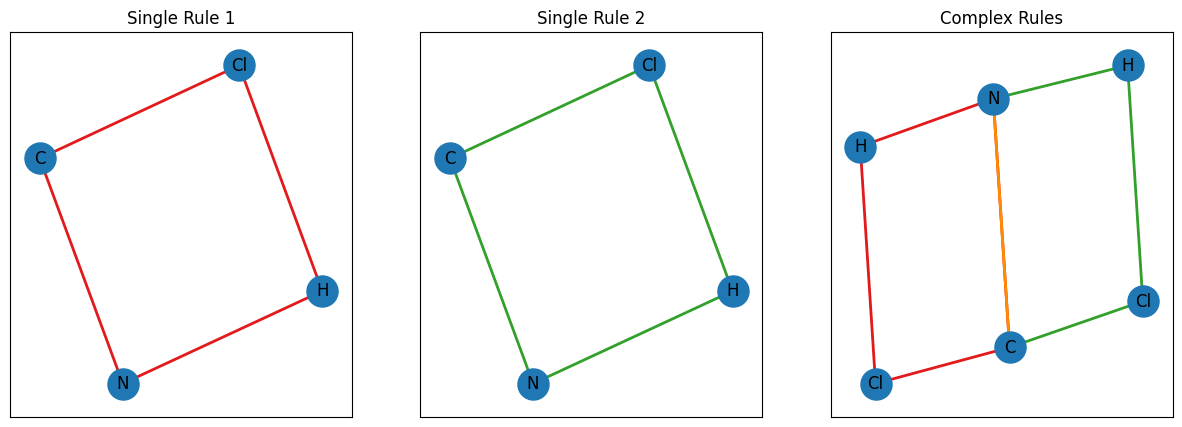

In [111]:
GrapRuleDecompose.visualize_with_common_subgraphs(complex_graph, explained_graphs)

In [68]:
list_ok = []
for key, value in enumerate(complex):
    single_cyclic_graphs = deepcopy(single)
    explained_graphs = GrapRuleDecompose.dfs_remove_isomorphic_subgraphs(value, single_cyclic_graphs)
    if explained_graphs is not None:
        list_ok.append(key)

In [11]:
len(list_ok)

6

In [41]:
import matplotlib.pyplot as plt
import networkx as nx
from typing import Dict, Any

def node_match(node1_attrs: Dict[str, Any], node2_attrs: Dict[str, Any]) -> bool:
    return (
        node1_attrs.get('element', None) == node2_attrs.get('element', None) and
        node1_attrs.get('charge', None) == node2_attrs.get('charge', None) and
        node1_attrs.get('aromatic', None) == node2_attrs.get('aromatic', None)
    )

def edge_match(edge1_attrs: Dict[str, Any], edge2_attrs: Dict[str, Any]) -> bool:
    order1 = edge1_attrs.get('standard_order', 0)
    order2 = edge2_attrs.get('standard_order', 0)
    return (np.sign(order1) == np.sign(order2)) if (order1 != 0 and order2 != 0) else True




def visualize_with_common_subgraphs(parent_graph, child_graphs):
    if len(child_graphs) != 2:
        print("This function requires exactly two child graphs.")
        return
    highlighted_edges = [] 
    plt.figure(figsize=(15, 5))
    node_color = '#1f78b4'  # Blue for nodes
    parent_edge_color = '#999999'  # Grey for parent edges not in common subgraphs
    common_colors = ['#e31a1c', '#33a02c']  # Red for common subgraph with child 1, Green for child 2
    overlap_color = '#ff8c00'  # Orange for overlapping common subgraphs


    for i, child_graph in enumerate(child_graphs, 1):
        plt.subplot(1, 3, i)
        pos = nx.spring_layout(child_graph)  # Compute layout
        # Draw all nodes
        nx.draw_networkx_nodes(child_graph, pos, node_color=node_color, node_size=500)
        # Draw all edges in default color first
        nx.draw_networkx_edges(child_graph, pos, edge_color='lightgrey', width=1)
        # Highlight common subgraph edges
        #matcher = nx.algorithms.isomorphism.GraphMatcher(parent_graph, child_graph, node_match=node_match, edge_match=edge_match)
        subgraph_isomorphism = GrapRuleDecompose.find_maximum_common_subgraph(parent_graph, child_graph, node_match=node_match, edge_match=edge_match)
        if subgraph_isomorphism:
            inverse_isomorphism = {v: u for u, v in subgraph_isomorphism.items()}  # Invert mapping for child to parent
            common_edges = [(u, v) for u, v in child_graph.edges() if u in inverse_isomorphism and v in inverse_isomorphism]
            nx.draw_networkx_edges(child_graph, pos, edgelist=common_edges, edge_color=common_colors[i-1], width=2)
        plt.title(f"Single Rule {i}")

    plt.subplot(1, 3, 3)
    pos = nx.spring_layout(parent_graph)
    # Draw all nodes in the parent graph
    nx.draw_networkx_nodes(parent_graph, pos, node_color=node_color, node_size=500)
    # Draw all edges in the parent graph in default color
    nx.draw_networkx_edges(parent_graph, pos, edge_color=parent_edge_color, width=1)
    # Draw node labels for the parent graph
    nx.draw_networkx_labels(parent_graph, pos)
    
    for i, child_graph in enumerate(child_graphs):
        subgraph_isomorphism = GrapRuleDecompose.find_maximum_common_subgraph(parent_graph, child_graph, node_match=node_match, edge_match=edge_match)
        print(subgraph_isomorphism)
        if subgraph_isomorphism:
            common_edges = []
            for u, v in child_graph.edges():
                complex_u, complex_v = GrapRuleDecompose.get_key_by_value(subgraph_isomorphism, u), GrapRuleDecompose.get_key_by_value(subgraph_isomorphism, v)
                if parent_graph.has_edge(complex_u, complex_v):
                    common_edges.append((complex_u, complex_v))
            for edge in common_edges:
                if edge in highlighted_edges:
                    # Edge is an overlap, color it orange
                    nx.draw_networkx_edges(parent_graph, pos, edgelist=[edge], edge_color=overlap_color, width=2)
                else:
                    # Color edge with child-specific color and add it to the tracking list
                    nx.draw_networkx_edges(parent_graph, pos, edgelist=[edge], edge_color=common_colors[i], width=2)
                    highlighted_edges.append(edge)
            print('***')
    plt.title("Complex Rules")
    plt.show()


{1: 8, 28: 14, 16: 9, 17: 7}
***
{27: 40, 1: 1, 17: 3, 18: 4}
***


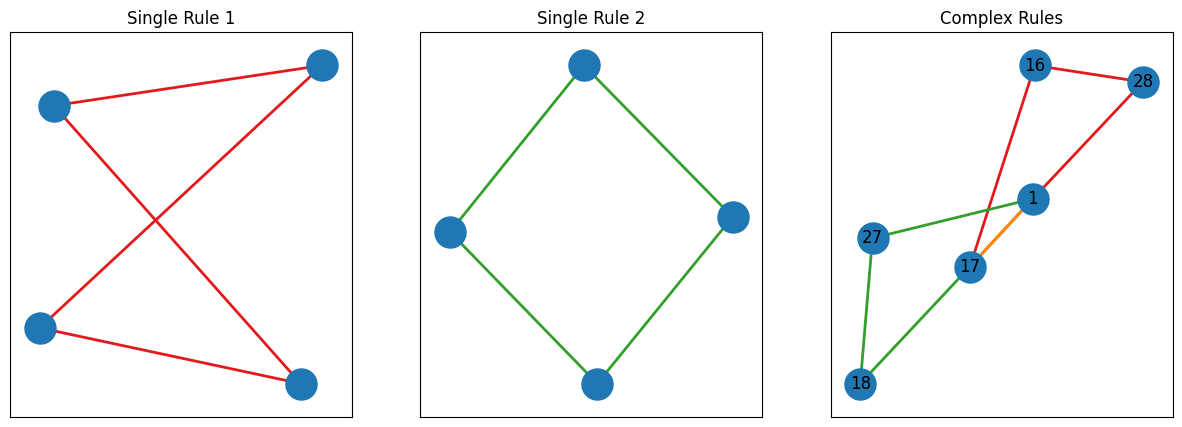

In [42]:
visualize_with_common_subgraphs(complex_graph, explained_graphs)

In [22]:
explained_graphs

In [14]:
import networkx as nx
import numpy as np
import sys
from copy import deepcopy
# Set a higher recursion limit
sys.setrecursionlimit(10000)

class GrapRuleDecompose:

    @staticmethod
    def get_key_by_value(dictionary, value):
        return next((key for key, val in dictionary.items() if val == value), None)

    @staticmethod
    def is_connected(graph):
        return nx.is_connected(graph)

    @staticmethod
    def remove_disconnected_part(graph):
        """
        Remove the smaller part of a disconnected graph.

        Parameters:
        - graph: NetworkX graph object

        Returns:
        - Modified graph with the smaller part of the disconnected graph removed.
        """
        if not GrapRuleDecompose.is_connected(graph):
            components = list(nx.connected_components(graph))
            largest_component = max(components, key=len)
            nodes_to_remove = [node for node in graph.nodes() if node not in largest_component]
            for node in nodes_to_remove:
                graph.remove_node(node)
        return graph

    @staticmethod
    def node_match(node1_attrs, node2_attrs):
        return (
            node1_attrs.get('element', None) == node2_attrs.get('element', None) and
            node1_attrs.get('charge', None) == node2_attrs.get('charge', None) and
            node1_attrs.get('aromatic', None) == node2_attrs.get('aromatic', None)
        )

    @staticmethod
    def edge_match(edge1_attrs, edge2_attrs):
        order1 = edge1_attrs.get('standard_order', 0)
        order2 = edge2_attrs.get('standard_order', 0)
        return (np.sign(order1) == np.sign(order2)) if (order1 != 0 and order2 != 0) else True

    @staticmethod
    def dfs_remove_isomorphic_subgraphs(complex_graph, single_cyclic_graphs, explained_graphs=[]):
        if not complex_graph.edges():
            return explained_graphs

        for single_graph in single_cyclic_graphs:
            matcher = nx.algorithms.isomorphism.GraphMatcher(complex_graph, single_graph, node_match=GrapRuleDecompose.node_match, 
                                                             edge_match=GrapRuleDecompose.edge_match)
            for isomorph in matcher.subgraph_isomorphisms_iter():
                complex_graph_copy = nx.Graph(complex_graph)
                for u, v, data in single_graph.edges(data=True):
                    complex_u, complex_v = GrapRuleDecompose.get_key_by_value(isomorph, u), GrapRuleDecompose.get_key_by_value(isomorph, v)
                    if complex_graph_copy.has_edge(complex_u, complex_v):
                        edge_data = complex_graph_copy.get_edge_data(complex_u, complex_v)
                        if 'standard_order' in data and 'standard_order' in edge_data:
                            if np.sign(data['standard_order']) == np.sign(edge_data['standard_order']) and abs(edge_data['standard_order']) >= abs(data['standard_order']):
                                complex_graph_copy.remove_edge(complex_u, complex_v)
                                if abs(edge_data['standard_order']) > abs(data['standard_order']):
                                    complex_graph_copy.add_edge(complex_u, complex_v, standard_order=edge_data['standard_order'] - data['standard_order'])
                GrapRuleDecompose.remove_disconnected_part(complex_graph_copy)
                result = GrapRuleDecompose.dfs_remove_isomorphic_subgraphs(complex_graph_copy, single_cyclic_graphs, explained_graphs + [single_graph])
                if result is not None:
                    return result

        return None
    

complex_graph = complex[3]
# Add nodes and edges to complex_graph with the required attributes

single_cyclic_graphs = deepcopy(single)
# Define your single cyclic graphs by adding nodes and edges with the required attributes

# Call the function
explained_graphs = GrapRuleDecompose.dfs_remove_isomorphic_subgraphs(complex_graph, single_cyclic_graphs)

if explained_graphs is not None:
    print("List of single cyclic graphs that explain the complex graph:", explained_graphs)
else:
    print("Some parts of the complex graph could not be explained by any of the single cyclic graphs.")

List of single cyclic graphs that explain the complex graph: [<networkx.classes.graph.Graph object at 0x7fa99cd317d0>, <networkx.classes.graph.Graph object at 0x7fa99e896ad0>]


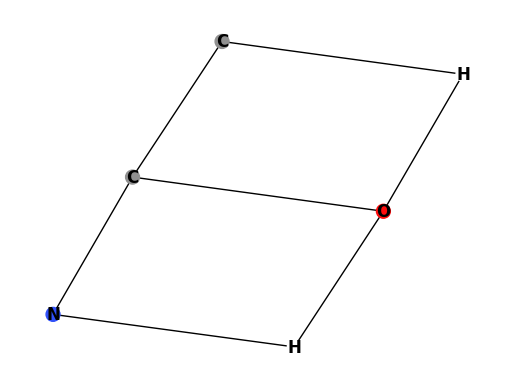

In [15]:
vis.graph_vis(complex_graph, show_node_labels=True)

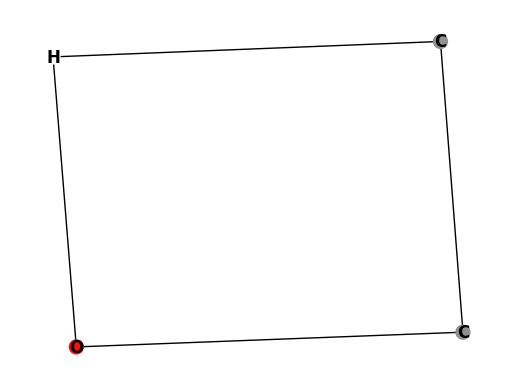

In [16]:
vis.graph_vis(explained_graphs[0], show_node_labels=True)

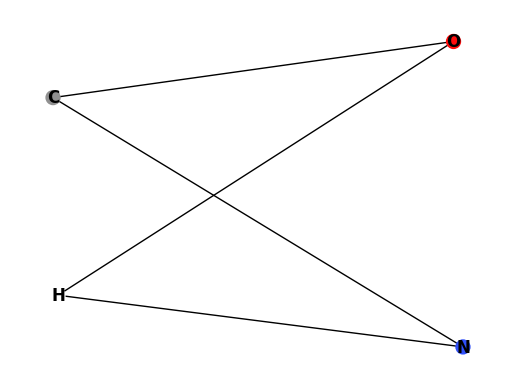

In [17]:
vis.graph_vis(explained_graphs[1], show_node_labels=True)

In [ ]:
complex_graph_copy = deepcopy(complex_graph)
for u, v, data in single_cyclic_graphs[3].edges(data=True):
    if u in isomorph.values() and v in isomorph.values():
        complex_u, complex_v = get_key_by_value(isomorph, u), get_key_by_value(isomorph, v)
        
        if complex_graph_copy.has_edge(complex_u, complex_v):
            edge_data = complex_graph_copy.get_edge_data(complex_u, complex_v)
            #print(1)
            if 'standard_order' in data and 'standard_order' in edge_data:
                if (np.sign(data['standard_order']) == np.sign(edge_data['standard_order']) and
                                abs(edge_data['standard_order']) >= abs(data['standard_order'])):
                    complex_graph_copy.remove_edge(complex_u, complex_v)
                    print(edge_data)  
                    print(data)
                    print("**")
                    print(complex_graph_copy)
                if abs(edge_data['standard_order']) > abs(data['standard_order']):
                    complex_graph_copy.add_edge(complex_u, complex_v, standard_order=data['standard_order'])
                    
                    print(complex_graph_copy)
    complex_graph_copy= remove_disconnected_part(complex_graph_copy)
    print(complex_graph_copy)


In [92]:
explained_graphs

In [74]:
matcher = isomorphism.GraphMatcher(complex_graph, single_cyclic_graphs[3], node_match=node_match, edge_match=edge_match)

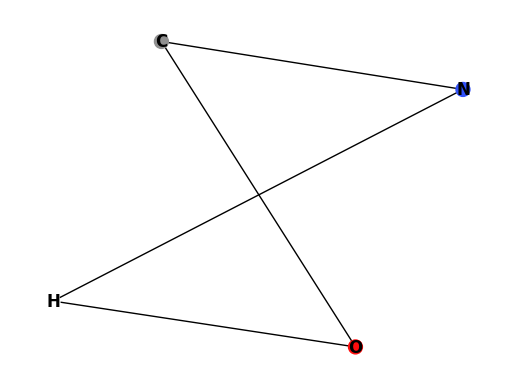

In [80]:
vis.graph_vis(single_cyclic_graphs[3], show_node_labels=True)

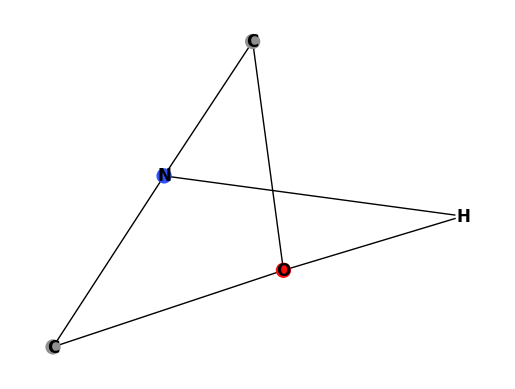

In [79]:
vis.graph_vis(complex_graph, show_node_labels=True)

In [76]:
for isomorph in matcher.subgraph_isomorphisms_iter():
    print(isomorph)
    #vis.graph_vis(isomorph)

{5: 4, 3: 5, 10: 44, 4: 7}


In [82]:
for i in single_cyclic_graphs[3].edges(data=True):
    print(i)

(4, 5, {'order': (2.0, 1.0), 'standard_order': 1.0})
(4, 44, {'order': (0, 1.0), 'standard_order': -1.0})
(5, 7, {'order': (0, 1.0), 'standard_order': -1.0})
(44, 7, {'order': (1.0, 0), 'standard_order': 1.0})


In [84]:
for u, v, data in complex_graph.edges(data=True):
    print(u, v, data)

3 5 {'order': (3.0, 1.0), 'standard_order': 2.0}
3 4 {'order': (0, 2.0), 'standard_order': -2.0}
5 6 {'order': (0, 1.0), 'standard_order': -1.0}
5 10 {'order': (0, 1.0), 'standard_order': -1.0}
6 4 {'order': (1.0, 0), 'standard_order': 1.0}
4 10 {'order': (1.0, 0), 'standard_order': 1.0}


In [83]:
for u, v, data in complex_graph.edges(data=True):
    if u in isomorph and v in isomorph:
        complex_u, complex_v = isomorph[u], isomorph[v]
        print(u, v, data)


3 5 {'order': (3.0, 1.0), 'standard_order': 2.0}
3 4 {'order': (0, 2.0), 'standard_order': -2.0}
5 10 {'order': (0, 1.0), 'standard_order': -1.0}
4 10 {'order': (1.0, 0), 'standard_order': 1.0}


In [137]:
complex_graph_copy = deepcopy(complex_graph)
for u, v, data in single_cyclic_graphs[3].edges(data=True):
    if u in isomorph.values() and v in isomorph.values():
        complex_u, complex_v = get_key_by_value(isomorph, u), get_key_by_value(isomorph, v)
        
        if complex_graph_copy.has_edge(complex_u, complex_v):
            edge_data = complex_graph_copy.get_edge_data(complex_u, complex_v)
            #print(1)
            if 'standard_order' in data and 'standard_order' in edge_data:
                if (np.sign(data['standard_order']) == np.sign(edge_data['standard_order']) and
                                abs(edge_data['standard_order']) >= abs(data['standard_order'])):
                    complex_graph_copy.remove_edge(complex_u, complex_v)
                    print(edge_data)  
                    print(data)
                    print("**")
                    print(complex_graph_copy)
                if abs(edge_data['standard_order']) > abs(data['standard_order']):
                    complex_graph_copy.add_edge(complex_u, complex_v, standard_order=data['standard_order'])
                    
                    print(complex_graph_copy)
    complex_graph_copy= remove_disconnected_part(complex_graph_copy)
    print(complex_graph_copy)


{'order': (3.0, 1.0), 'standard_order': 2.0}
{'order': (2.0, 1.0), 'standard_order': 1.0}
**
Graph with 5 nodes and 5 edges
Graph with 5 nodes and 6 edges
Graph with 5 nodes and 6 edges
{'order': (0, 1.0), 'standard_order': -1.0}
{'order': (0, 1.0), 'standard_order': -1.0}
**
Graph with 5 nodes and 5 edges
Graph with 5 nodes and 5 edges
{'order': (0, 2.0), 'standard_order': -2.0}
{'order': (0, 1.0), 'standard_order': -1.0}
**
Graph with 5 nodes and 4 edges
Graph with 5 nodes and 5 edges
Graph with 5 nodes and 5 edges
{'order': (1.0, 0), 'standard_order': 1.0}
{'order': (1.0, 0), 'standard_order': 1.0}
**
Graph with 5 nodes and 4 edges
Graph with 4 nodes and 4 edges


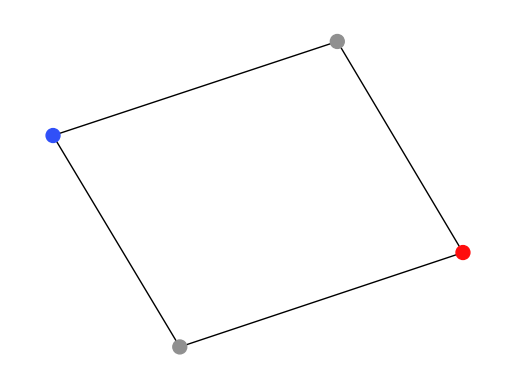

In [138]:
vis.graph_vis(complex_graph_copy)

In [135]:
complex_graph_copy= remove_disconnected_part(complex_graph_copy)

In [136]:
print(complex_graph_copy)

Graph with 4 nodes and 4 edges


In [132]:
G.nodes()

NodeView((3, 5, 6, 4))

In [122]:
connected

True

In [117]:
complex_graph_copy.nodes()

NodeView((3, 5, 6, 4, 10))

In [118]:
complex_graph_copy.edges()

EdgeView([(3, 5), (3, 4), (5, 6), (6, 4)])

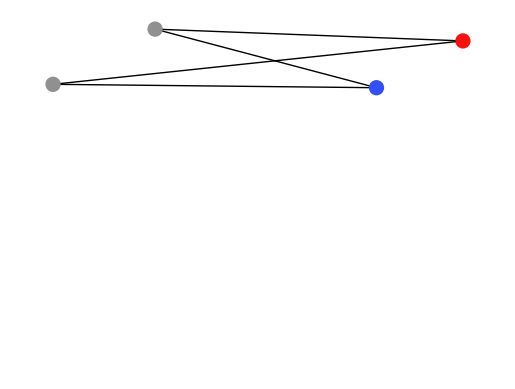

In [116]:
vis.graph_vis(complex_graph_copy)

In [86]:
isomorph.values()

dict_values([4, 5, 44, 7])

In [87]:
isomorph

{5: 4, 3: 5, 10: 44, 4: 7}

In [ ]:
vis.graph_vis(complex[2], show_node_labels=True)

In [88]:
def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None 

In [ ]:
complex_graph

In [ ]:
data = pd.read_csv('./Data/USPTO_sampled.csv', index_col=0).to_dict('records')
data[0]

In [ ]:
from SynTemp.SynITS.its_extraction import ITSExtraction
mapper_name = ['RXNMapper', 'GraphMapper', 'LocalMapper']
its_graph, its_graph_wrong = ITSExtraction.parallel_process_smiles(data, mapper_name, threshold=2, n_jobs=5, verbose=1, export_full=False, check_method='RC')
len(its_graph)

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results = AMMValidator.validate_smiles(data=data, ground_truth_col='LocalMapper', 
                                       mapped_cols=['RXNMapper', 'GraphMapper'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0)

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results = AMMValidator.validate_smiles(data=data, ground_truth_col='Ground turth', 
                                       mapped_cols=['RXNMapper', 'GraphMapper', 'LocalMapper'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0)

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [44]:
import pandas as pd
from SynTemp.SynUtils.utils import load_database, save_database, load_from_pickle

df = pd.read_csv('./Data/uspto_sample/uspto_sample.csv')
df.rename(columns={'sampled_id':'R-id', 'RXNMapper':'rxn_mapper', "GraphMapper": "graphormer",
                   "LocalMapper": "local_mapper"}, inplace=True)
df = df[['R-id','rxn_mapper', 'graphormer', 'local_mapper']].to_dict('records')

save_database(df, './Data/uspto_sample/uspto_sample_aam_reactions.json.gz')

In [45]:
data = load_from_pickle('./Data/uspto_sample/uspto_sample_its_graph_rules_cluster.pkl.gz')

In [46]:
data = [value for value in data if value['Reaction Type'] == 'Single Cyclic']


In [47]:
id =30602
test = [value for value in df if value['R-id']==id]
test

[{'R-id': 30602,
  'rxn_mapper': 'CC(=O)O[BH-](OC(C)=O)OC(C)=O.[CH3:1][S:2][c:3]1[cH:4][cH:5][c:6]([NH2:7])[cH:16][n:17]1.ClCCl.O=[CH:8][c:9]1[cH:10][cH:11][c:12]([F:13])[cH:14][cH:15]1.[Na+]>>[CH3:1][S:2][c:3]1[cH:4][cH:5][c:6]([NH:7][CH2:8][c:9]2[cH:10][cH:11][c:12]([F:13])[cH:14][cH:15]2)[cH:16][n:17]1',
  'graphormer': '[Cl:25][CH2:24][Cl:23].[Na+:35].[O:4]([C:2](=[O:3])[CH3:1])[BH-:5]([O:10][C:11](=[O:13])[CH3:12])[O:6][C:7](=[O:9])[CH3:8].[c:16]1([cH:17][cH:18][c:19]([cH:21][n:22]1)[NH2:20])[S:15][CH3:14].[cH:34]1[cH:33][c:31]([cH:30][cH:29][c:28]1[CH:27]=[O:26])[F:32]>>[cH:30]1[cH:29][c:28]([cH:34][cH:33][c:31]1[F:32])[CH2:27][NH:20][c:19]2[cH:18][cH:17][c:16]([n:22][cH:21]2)[S:15][CH3:14]',
  'local_mapper': 'CC(=O)O[BH-](OC(C)=O)OC(C)=O.ClCCl.O=[CH:1][c:2]1[cH:3][cH:4][c:5]([F:6])[cH:7][cH:8]1.[CH3:15][S:14][c:13]1[cH:12][cH:11][c:10]([NH2:9])[cH:17][n:16]1.[Na+]>>[CH2:1]([c:2]1[cH:3][cH:4][c:5]([F:6])[cH:7][cH:8]1)[NH:9][c:10]1[cH:11][cH:12][c:13]([S:14][CH3:15])[n:16][cH:17]

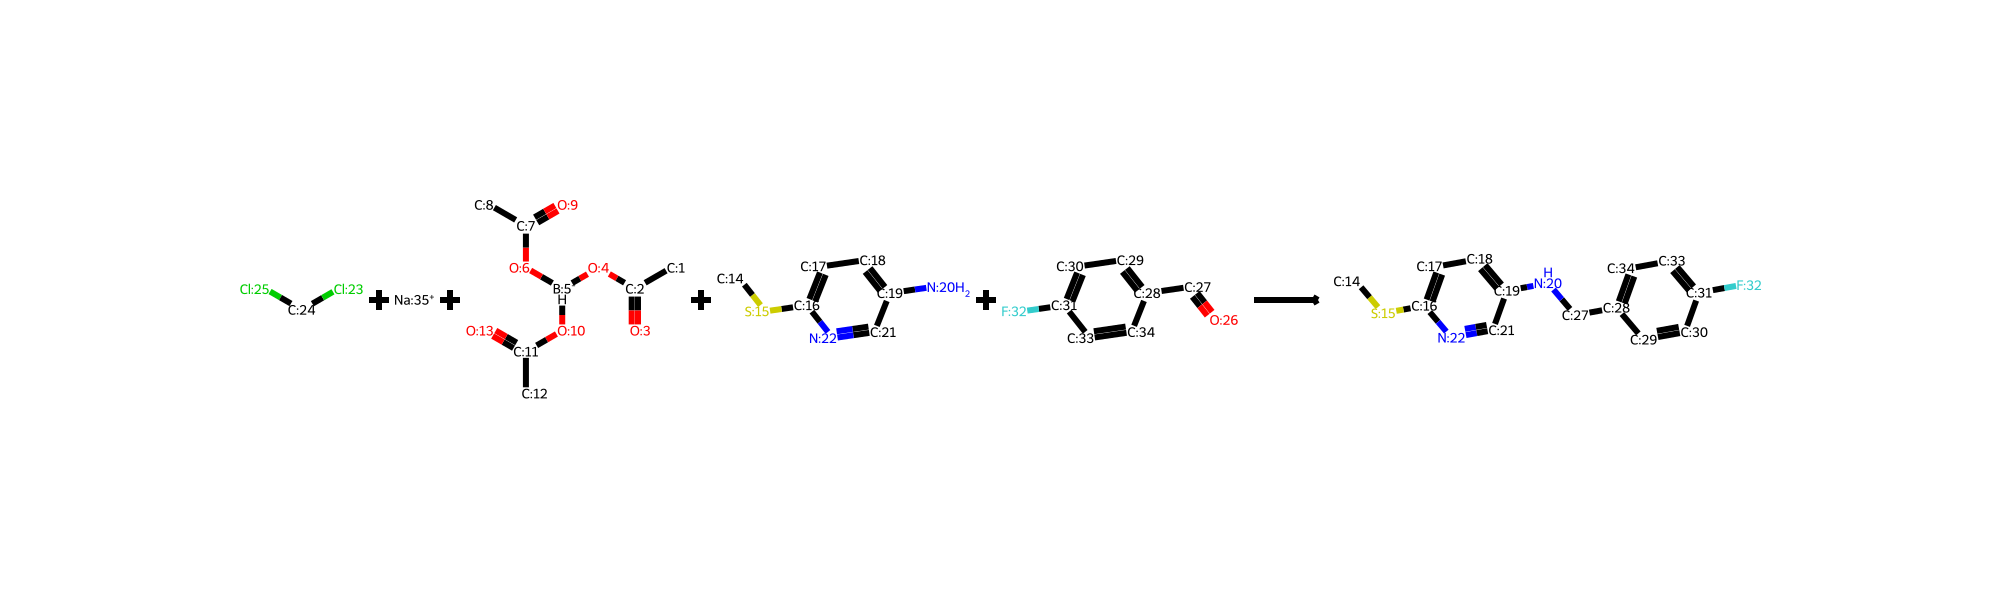

In [48]:
from SynTemp.SynVis.reaction_visualizer import ReactionVisualizer
reaction_vis = ReactionVisualizer()

reaction_vis.visualize_reaction(test[0]['graphormer'])

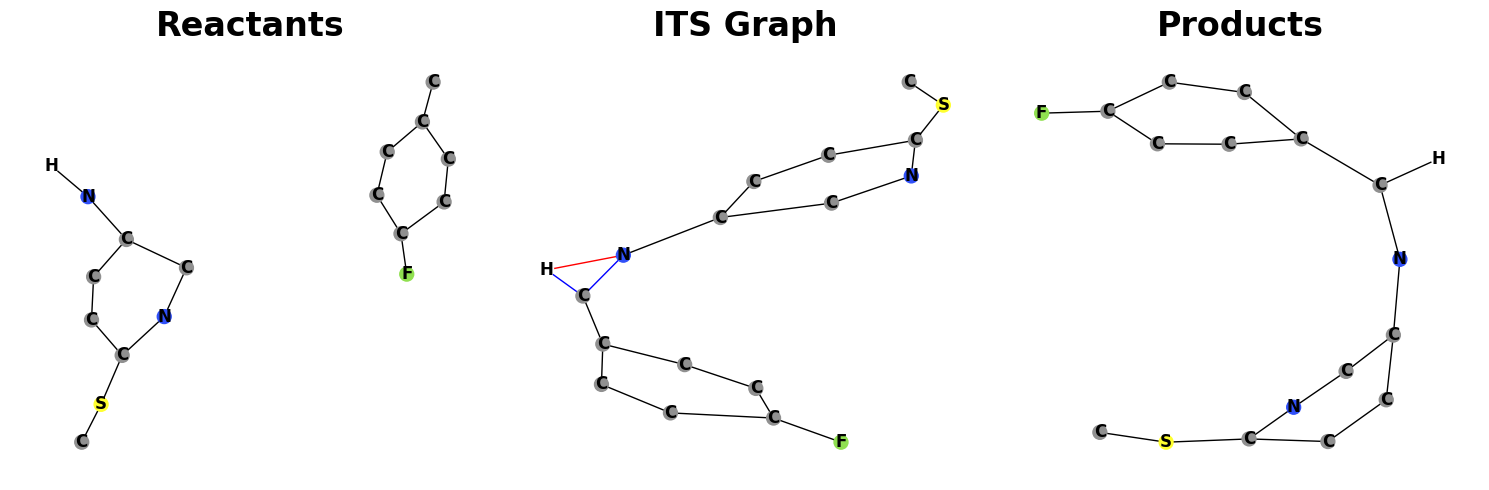

In [49]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis_graph = ChemicalGraphVisualizer()

vis_graph.visualize_all([value for value in data if value['R-id']==id][0]['ITSGraph'])

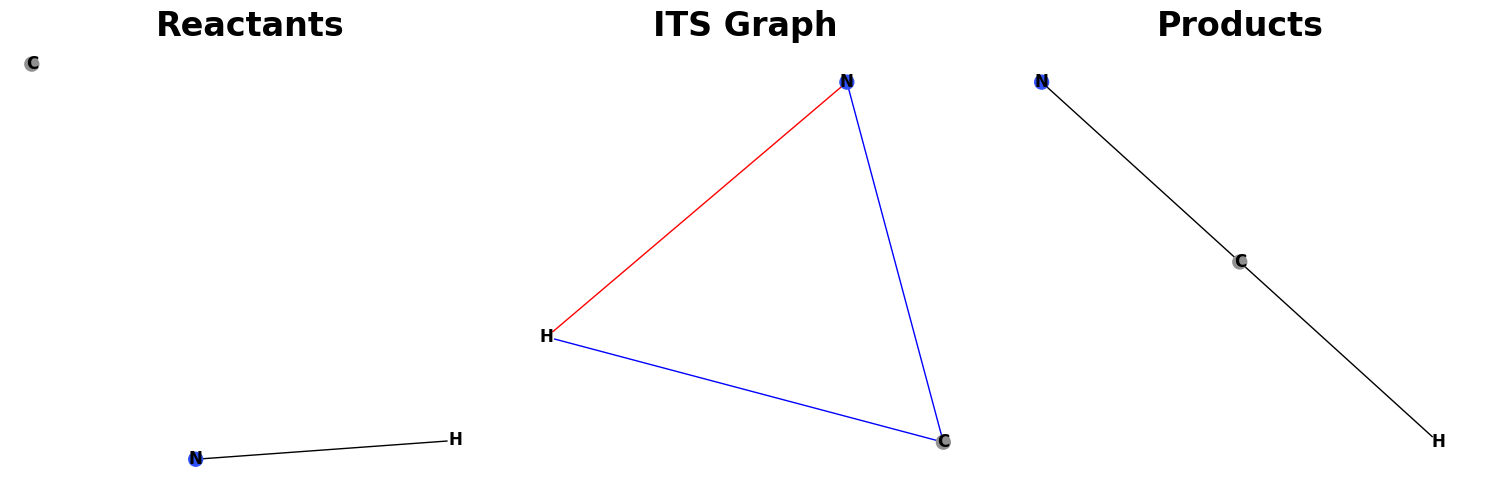

In [50]:
vis_graph.visualize_all([value for value in data if value['R-id']==id][0]['GraphRules'])

In [52]:
from SynTemp.SynMØD.MØD_rules import MØDRules
process_graphs = [value for value in data if value['R-id']==id]
results = MØDRules.auto_extraction(process_graphs, reindex=True, save_path='./Data/uspto_sample', rule_column='GraphRules')
print(results[0])

rule [
   ruleID "30602"
   left [
      edge [ source 2 target 3 label "-" ]
   ]
   context [
      node [ id 1 label "C" ]
      node [ id 2 label "H" ]
      node [ id 3 label "N" ]
   ]
   right [
      edge [ source 1 target 3 label "-" ]
      edge [ source 1 target 2 label "-" ]
      edge [ source 2 target 3 label "-" ]
   ]
]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [9]:
from rdkit import Chem
chiral_smiles = 'CC[C@@H](C)O'
chiral_mol = Chem.MolFromSmiles(chiral_smiles)
chiral_atom = chiral_mol.GetAtomWithIdx(1) 

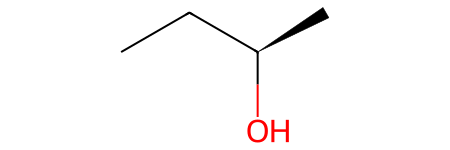

In [10]:
chiral_mol

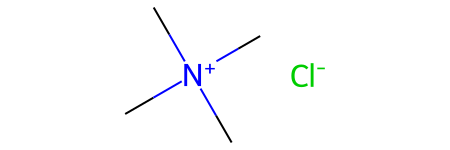

In [13]:
Chem.MolFromSmiles('C[N+](C)(C)C.[Cl-]')